<h1 style="display: flex; align-items: center; font-size: 35px">
    <img src="../assets/icons/deep-learning_2.png" style="width: 50px; height: 50px; margin-right: 10px;">
    <strong>MRI Brain Alzheimer Classification - EfficientNet Model</strong>
</h1>

****

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-git-48.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Clone Repository from GitHub
</h1>


In [1]:
# Clone repository from GitHub
# !git clone https://github.com/nivbartov/MRI_Brain_Alzheimer_Classification

# %cd MRI_Brain_Alzheimer_Classification
%cd ..

c:\Dor\TECHNION\deep_learning\Project\MRI_Brain_Alzheimer_Classification


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-import-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Import Packages
</h1>


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import sys
import os
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset, ConcatDataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import random
import time
from datetime import datetime
import json
import gc
import subprocess

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-function-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Import Internal Functions
</h1>


In [4]:
from models import def_models
from utils import utils_funcs
from utils import optuna_search

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-gpu-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Define Definition
</h1>

In [5]:
print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')
torch.cuda.empty_cache()
gc.collect()
utils_funcs.open_nvitop()

torch.cuda.is_available(): True
device: cuda:0


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-load-50.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Load Dataset
</h1>

In [6]:
train_set = torch.load('dataset/dataset_variables/train_set.pt')
validation_set = torch.load('dataset/dataset_variables/validation_set.pt')
test_set = torch.load('dataset/dataset_variables/test_set.pt')

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-data-recovery-40.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Model Definition and Initialization
</h1>

In [7]:
# Initialize input and output sizes
input_width = 224
input_height = 224
input_channels = 3
output_channels = 4

# Load a pre-trained EfficientNet-B0 model
EfficientNet_backbone_model = torchvision.models.efficientnet_b0(pretrained=True)

# Finetune EfficientNet-B0 layers
for param in EfficientNet_backbone_model.parameters():
    param.requires_grad = True

# Create EfficientNet-B0 model with FC layers before the output
model = def_models.EfficientNet(EfficientNet_backbone=EfficientNet_backbone_model, output_channels=output_channels).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 46.3MB/s]


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-statistics-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Model statistics
</h1>

In [8]:
model_name = type(model).__name__
print("Model", model_name, "Statistics:")
summary(model, (input_channels, input_height, input_width))

Model EfficientNet Statistics:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      Ba

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-tuna-50.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Set Hyper-Parameters Using Optuna
</h1>

In [9]:
load_existing_hyperparams = False

if load_existing_hyperparams:
    # Load hyper-parameters (relevant if optuna has already used)
    optuna_params_path = f'./checkpoints/optuna_params/{model_name}/EfficientNet_0.8901.json'
    with open(optuna_params_path, 'r') as file:
        hyperparams = json.load(file)
else:
    # Find optimal hyper-parameters using optuna
    torch.cuda.empty_cache()
    hyperparams = optuna_search.optuna_param_search(model_name="EfficientNet", loss_criterion=nn.CrossEntropyLoss(), num_epochs_for_experiments=10, device=device, transfer_learning=True)

print(hyperparams)

[I 2024-10-17 07:45:51,493] A new study created in memory with name: mri-alzhimer-classification


Optuna is done on device: cuda:0


100%|██████████| 10/10 [01:03<00:00,  6.38s/it]
[I 2024-10-17 07:46:56,204] Trial 0 finished with value: 0.7625 and parameters: {'lr': 1.8229106413373008e-05, 'optimizer': 'RMSprop', 'batch_size': 32, 'scheduler': 'CosineAnnealingLR'}. Best is trial 0 with value: 0.7625.
100%|██████████| 10/10 [02:08<00:00, 12.84s/it]
[I 2024-10-17 07:49:04,835] Trial 1 finished with value: 0.8109375 and parameters: {'lr': 0.005906701547624786, 'optimizer': 'Adam', 'batch_size': 64, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 0.8109375.
100%|██████████| 10/10 [02:07<00:00, 12.79s/it]
[I 2024-10-17 07:51:12,996] Trial 2 finished with value: 0.61875 and parameters: {'lr': 3.7111230493135953e-06, 'optimizer': 'Adam', 'batch_size': 64, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 0.8109375.
100%|██████████| 10/10 [01:01<00:00,  6.11s/it]
[I 2024-10-17 07:52:14,362] Trial 3 finished with value: 0.678125 and parameters: {'lr': 0.002384250024131759, 'optimizer': 'SGD', 'ba

Study statistics: 
  Number of finished trials:  35
  Number of pruned trials:  20
  Number of complete trials:  15
Best trial:
  Value:  0.8671875
  Params: 
    lr: 0.0006244533537392306
    optimizer: Adam
    batch_size: 64
    scheduler: CosineAnnealingLR
Best parameters saved to checkpoints/optuna_params/EfficientNet/EfficientNet_0.8672.json
{'lr': 0.0006244533537392306, 'optimizer': 'Adam', 'batch_size': 64, 'scheduler': 'CosineAnnealingLR'}


In [10]:
# Set hyper-parameters
batch_size = hyperparams['batch_size']
learning_rate = hyperparams['lr']
optimizer_name = hyperparams['optimizer']
optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
num_epochs = 35
scheduler = hyperparams['scheduler']
scheduler = StepLR(optimizer, 10, 0.1, verbose=True) if scheduler == "StepLR" else CosineAnnealingLR(optimizer, num_epochs, verbose=True)
criterion = nn.CrossEntropyLoss()

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-augmentation-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Data Augmentations
</h1>

In [11]:
augmentations = K.AugmentationSequential(
    K.RandomHorizontalFlip(p=0.1),
    K.RandomVerticalFlip(p=0.1),
    K.RandomRotation(degrees=10, p=0.1),
    K.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), p=0.1),
    K.RandomBrightness(brightness=(0.8, 1.2), p=0.1),
    K.RandomContrast(contrast=(0.8, 1.2), p=0.1),
    K.RandomGamma(gamma=(0.9, 1.1), p=0.1),
    K.RandomSharpness(p=0.1),
    same_on_batch=False
)

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-loader-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Create Data Loaders
</h1>


In [12]:
# Data loading and shuffling
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-training-100.png" style="width: 50px; height: 50px; margin-right: 5px;">
    Train Model
</h1>

In [13]:
load_existing_params = False
train_loaded_model = False

if load_existing_params:
    model_path = './checkpoints/EfficientNet_225106_16102024/EfficientNet_001249_17102024_train_0.0434_val_0.1027.pth'
    checkpoint = torch.load(model_path, weights_only=True)
    model.load_state_dict(checkpoint['net'])
    if (train_loaded_model):
        epoch_train_losses, epoch_validation_losses, epoch_train_accuracies, epoch_validation_accuracies = utils_funcs.train_model(model, num_epochs, trainloader, validationloader, device, criterion, optimizer, scheduler, augmentations, use_amp=True)
    else:
        # Load the saved values from the checkpoint
        epoch_train_losses = checkpoint['train_epoch_losses']
        epoch_validation_losses = checkpoint['validation_epoch_losses']
        epoch_train_accuracies = checkpoint['train_epoch_accuracies']
        epoch_validation_accuracies = checkpoint['validation_epoch_accuracies']
        num_epochs = checkpoint['epoch']
else:
    epoch_train_losses, epoch_validation_losses, epoch_train_accuracies, epoch_validation_accuracies = utils_funcs.train_model(model, num_epochs, trainloader, validationloader, device, criterion, optimizer, scheduler, augmentations, use_amp=True)

Created training session directory: ./checkpoints/EfficientNet_083104_17102024
Training model: EfficientNet on cuda:0


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


Epoch: 1 | Training Loss: 0.5722 | Training Accuracy: 84.644% | Validation Loss: 0.4404 | Validation Accuracy: 82.373% | Epoch Time: 101.88 secs


Validation: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


Epoch: 2 | Training Loss: 0.3644 | Training Accuracy: 91.870% | Validation Loss: 0.3712 | Validation Accuracy: 87.744% | Epoch Time: 99.09 secs


Validation: 100%|██████████| 32/32 [00:11<00:00,  2.71it/s]


Epoch: 3 | Training Loss: 0.2820 | Training Accuracy: 96.228% | Validation Loss: 0.2644 | Validation Accuracy: 92.285% | Epoch Time: 98.98 secs


Validation: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]


Epoch: 4 | Training Loss: 0.2230 | Training Accuracy: 95.923% | Validation Loss: 0.2668 | Validation Accuracy: 91.748% | Epoch Time: 100.84 secs


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]


Epoch: 5 | Training Loss: 0.1704 | Training Accuracy: 98.547% | Validation Loss: 0.1930 | Validation Accuracy: 95.264% | Epoch Time: 98.99 secs
==> Saving model ...
Saved as ./checkpoints/EfficientNet_083104_17102024/EfficientNet_083924_17102024_train_0.1704_val_0.1930.pth


Validation: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]


Epoch: 6 | Training Loss: 0.1335 | Training Accuracy: 98.987% | Validation Loss: 0.1645 | Validation Accuracy: 95.703% | Epoch Time: 100.24 secs


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]


Epoch: 7 | Training Loss: 0.1170 | Training Accuracy: 98.218% | Validation Loss: 0.2089 | Validation Accuracy: 93.799% | Epoch Time: 100.18 secs


Validation: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]


Epoch: 8 | Training Loss: 0.1074 | Training Accuracy: 99.072% | Validation Loss: 0.1501 | Validation Accuracy: 95.801% | Epoch Time: 95.40 secs


Validation: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]


Epoch: 9 | Training Loss: 0.0851 | Training Accuracy: 99.768% | Validation Loss: 0.1172 | Validation Accuracy: 97.461% | Epoch Time: 94.06 secs


Validation: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


Epoch: 10 | Training Loss: 0.0709 | Training Accuracy: 99.121% | Validation Loss: 0.1557 | Validation Accuracy: 96.631% | Epoch Time: 100.36 secs
==> Saving model ...
Saved as ./checkpoints/EfficientNet_083104_17102024/EfficientNet_084734_17102024_train_0.0709_val_0.1557.pth


Validation: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]


Epoch: 11 | Training Loss: 0.0681 | Training Accuracy: 99.768% | Validation Loss: 0.1233 | Validation Accuracy: 97.900% | Epoch Time: 100.11 secs


Validation: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


Epoch: 12 | Training Loss: 0.0600 | Training Accuracy: 99.963% | Validation Loss: 0.0898 | Validation Accuracy: 98.340% | Epoch Time: 98.91 secs


Validation: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


Epoch: 13 | Training Loss: 0.0527 | Training Accuracy: 99.951% | Validation Loss: 0.0801 | Validation Accuracy: 98.730% | Epoch Time: 94.10 secs


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]


Epoch: 14 | Training Loss: 0.0455 | Training Accuracy: 99.988% | Validation Loss: 0.0702 | Validation Accuracy: 98.633% | Epoch Time: 99.25 secs


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


Epoch: 15 | Training Loss: 0.0420 | Training Accuracy: 99.939% | Validation Loss: 0.0927 | Validation Accuracy: 98.535% | Epoch Time: 98.52 secs
==> Saving model ...
Saved as ./checkpoints/EfficientNet_083104_17102024/EfficientNet_085545_17102024_train_0.0420_val_0.0927.pth


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


Epoch: 16 | Training Loss: 0.0337 | Training Accuracy: 99.866% | Validation Loss: 0.0764 | Validation Accuracy: 98.730% | Epoch Time: 99.59 secs


Validation: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]


Epoch: 17 | Training Loss: 0.0340 | Training Accuracy: 99.963% | Validation Loss: 0.0757 | Validation Accuracy: 98.291% | Epoch Time: 97.97 secs


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]


Epoch: 18 | Training Loss: 0.0270 | Training Accuracy: 99.963% | Validation Loss: 0.0712 | Validation Accuracy: 98.535% | Epoch Time: 99.24 secs


Validation: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]


Epoch: 19 | Training Loss: 0.0292 | Training Accuracy: 99.963% | Validation Loss: 0.0697 | Validation Accuracy: 99.219% | Epoch Time: 100.10 secs


Validation: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]


Epoch: 20 | Training Loss: 0.0194 | Training Accuracy: 99.988% | Validation Loss: 0.0518 | Validation Accuracy: 99.268% | Epoch Time: 100.08 secs
==> Saving model ...
Saved as ./checkpoints/EfficientNet_083104_17102024/EfficientNet_090402_17102024_train_0.0194_val_0.0518.pth


Validation: 100%|██████████| 32/32 [00:11<00:00,  2.85it/s]


Epoch: 21 | Training Loss: 0.0177 | Training Accuracy: 99.976% | Validation Loss: 0.0658 | Validation Accuracy: 98.584% | Epoch Time: 88.61 secs


Validation: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]


Epoch: 22 | Training Loss: 0.0158 | Training Accuracy: 100.000% | Validation Loss: 0.0579 | Validation Accuracy: 98.926% | Epoch Time: 98.75 secs


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]


Epoch: 23 | Training Loss: 0.0171 | Training Accuracy: 100.000% | Validation Loss: 0.0574 | Validation Accuracy: 99.121% | Epoch Time: 99.92 secs


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]


Epoch: 24 | Training Loss: 0.0110 | Training Accuracy: 100.000% | Validation Loss: 0.0600 | Validation Accuracy: 99.121% | Epoch Time: 98.74 secs


Validation: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]


Epoch: 25 | Training Loss: 0.0097 | Training Accuracy: 100.000% | Validation Loss: 0.0441 | Validation Accuracy: 99.072% | Epoch Time: 100.16 secs
==> Saving model ...
Saved as ./checkpoints/EfficientNet_083104_17102024/EfficientNet_091209_17102024_train_0.0097_val_0.0441.pth


Validation: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


Epoch: 26 | Training Loss: 0.0106 | Training Accuracy: 100.000% | Validation Loss: 0.0473 | Validation Accuracy: 99.072% | Epoch Time: 98.96 secs


Validation: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


Epoch: 27 | Training Loss: 0.0079 | Training Accuracy: 100.000% | Validation Loss: 0.0559 | Validation Accuracy: 99.219% | Epoch Time: 100.20 secs


Validation: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]


Epoch: 28 | Training Loss: 0.0078 | Training Accuracy: 100.000% | Validation Loss: 0.0370 | Validation Accuracy: 99.268% | Epoch Time: 91.82 secs


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]


Epoch: 29 | Training Loss: 0.0074 | Training Accuracy: 100.000% | Validation Loss: 0.0460 | Validation Accuracy: 99.268% | Epoch Time: 97.69 secs


Validation: 100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Epoch: 30 | Training Loss: 0.0064 | Training Accuracy: 100.000% | Validation Loss: 0.0409 | Validation Accuracy: 99.316% | Epoch Time: 99.76 secs
==> Saving model ...
Saved as ./checkpoints/EfficientNet_083104_17102024/EfficientNet_092017_17102024_train_0.0064_val_0.0409.pth


Validation: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


Epoch: 31 | Training Loss: 0.0083 | Training Accuracy: 100.000% | Validation Loss: 0.0396 | Validation Accuracy: 99.316% | Epoch Time: 102.33 secs


Validation: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


Epoch: 32 | Training Loss: 0.0040 | Training Accuracy: 100.000% | Validation Loss: 0.0383 | Validation Accuracy: 99.414% | Epoch Time: 100.74 secs


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


Epoch: 33 | Training Loss: 0.0048 | Training Accuracy: 100.000% | Validation Loss: 0.0424 | Validation Accuracy: 99.316% | Epoch Time: 98.42 secs


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]


Epoch: 34 | Training Loss: 0.0032 | Training Accuracy: 100.000% | Validation Loss: 0.0380 | Validation Accuracy: 99.316% | Epoch Time: 103.19 secs


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.67it/s]


Epoch: 35 | Training Loss: 0.0044 | Training Accuracy: 100.000% | Validation Loss: 0.0401 | Validation Accuracy: 99.316% | Epoch Time: 100.34 secs
==> Saving model ...
Saved as ./checkpoints/EfficientNet_083104_17102024/EfficientNet_092843_17102024_train_0.0044_val_0.0401.pth


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-results-58.png" style="width: 50px; height: 50px; margin-right: 5px;">
    Results
</h1>

In [14]:
test_accuracy = utils_funcs.calculate_accuracy(model, testloader, device)
print("Test accuracy: {:.3f}%".format(test_accuracy))

Test accuracy: 98.905%


<Figure size 800x600 with 0 Axes>

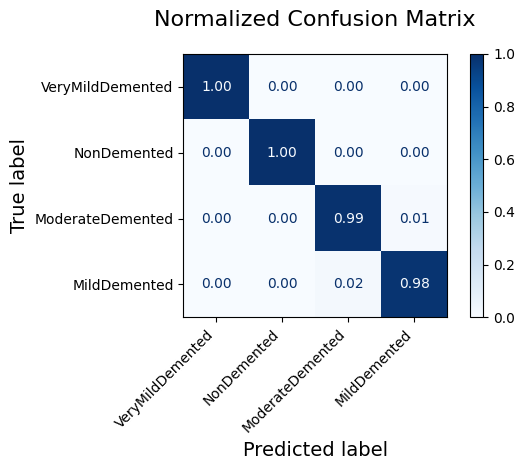

In [15]:
class_names = ['VeryMildDemented', 'NonDemented', 'ModerateDemented', 'MildDemented']
utils_funcs.plot_normalized_confusion_matrix(testloader, model, class_names, device, model_name)

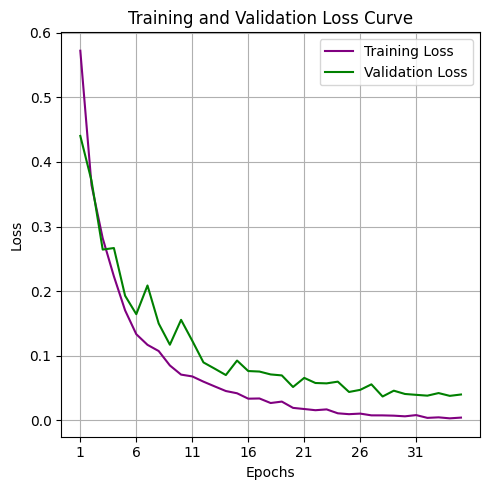

In [16]:
utils_funcs.plot_loss_curve(epoch_train_losses, epoch_validation_losses, num_epochs, model_name)

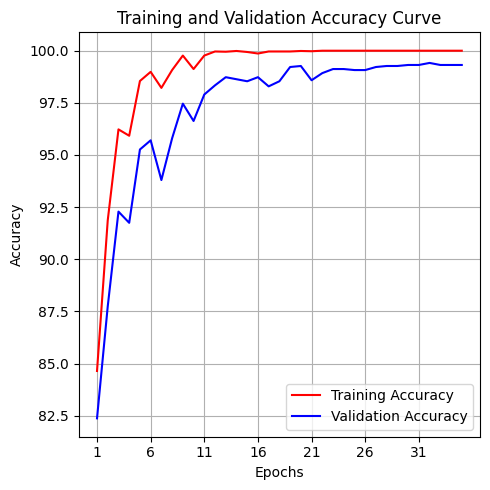

In [17]:
utils_funcs.plot_accuracy_curve(epoch_train_accuracies, epoch_validation_accuracies, num_epochs, model_name)